In [3]:
import pickle
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.utils import shuffle
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score

def sort_data_random(df):
    np.random.seed(0)
    df['random'] = np.random.random(size=len(df))
    sorted_df = df.sort_values(by=['fitness', 'random'], ascending=[False, True])
    sorted_df = sorted_df.drop(columns=['random'])
    return sorted_df

def calc_normalized_data(data, target_columns, scaler_dict):
    for target in target_columns:
        mean, std = scaler_dict[target]
        normalized_scores = [(s-mean)/std for s in data[target]]
        data["normalized "+target] = normalized_scores
    return data

def sample_data(sub_dir_name, target_columns, scaler_dict, cache_dict, num_fold, root_dir, sample_num):
    data_dict = {}
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            continue
        smiles2fitness_dict = {}
        all_smiles_list = []
        for i in range(1, num_fold+1):
            smiles_list = []
            fitness_list = []
            dir_name = os.path.join(root_dir, sub_dir+"_"+str(i))
            with open(os.path.join(dir_name, "population_explore.txt"), "r") as f:
                smiles_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "fitness_explore.txt"), "r") as f:
                fitness_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "population_local_search.txt"), "r") as f:
                smiles_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "fitness_local_search.txt"), "r") as f:
                fitness_list += f.read().strip().split(" ")
            fitness_list = [float(x) for x in fitness_list]
            for smiles, fitness in zip(smiles_list, fitness_list):
                smiles2fitness_dict.update({smiles: fitness})            
            smiles_fitness_data = list(zip(smiles_list, fitness_list))
            unique_data = set_and_sort(smiles_fitness_data)
            all_smiles_list += list(zip(*unique_data[:sample_num]))[0]
        data = pd.DataFrame(columns=target_columns)
        all_smiles_list = list(set(all_smiles_list))
        for smiles in all_smiles_list:
            scores = cache_dict.get(smiles)
            if scores:
                if abs(scores[0]) != 10000:
                    scores = list(scores)
                    data = pd.concat([data, pd.DataFrame([[smiles]+scores], columns=["smiles"]+target_columns)], axis=0)
                else:
                    score = float("nan")
        data = calc_normalized_data(data, target_columns, scaler_dict)
        data["fitness"] = [smiles2fitness_dict.get(smiles) for smiles in data["smiles"]]
        data_dict.update({sub_dir: sort_data_random(data).reset_index(drop=True)})
        
#         data_dict.update({sub_dir: data})
    return data_dict

def set_and_sort(data):
    seen_names = set()
    unique_data = []
    for name, score in data:
        if name not in seen_names:
            seen_names.add(name)
            unique_data.append((name, score))
    unique_data.sort(key=lambda x: x[1], reverse=True)
    return unique_data

def create3Dplot(sub_dir_name, data_dict, color_dict, target_columns, target_objective, cutoff_dict,
                purple_line_label="top-15% cutoff", top_num=50):
    target_name_dict = {"singlet-triplet value":"singlet-triplet value", "oscillator strength":"oscillator strength", 
                        "abs_diff_vee":"absolute difference of \n vertical excitation energy",}
    start_point = [cutoff_dict[target] for target in target_columns]  
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            continue
        data_dict.update({sub_dir: data_dict[sub_dir][:top_num]})
    
    extreme_point = [min(pd.concat([*data_dict.values()], axis=0)[target]) if target_objective[target]=="minimize" else max(pd.concat([*data_dict.values()], axis=0)[target]) for target in target_columns]
    end_x, end_y, end_z = extreme_point
    start_x, start_y, start_z = cutoff_dict[target_columns[0]], cutoff_dict[target_columns[1]], cutoff_dict[target_columns[2]]
    print(start_x, start_y, start_z)
    print(end_x, end_y, end_z)
    # 0.0116198315518392 0.9237570437583232 0.0023723931799306
    end_x = 0.0; end_y = 3.3; end_z = 0.0
#     start_x, end_x = min(start_x, end_x), max(start_x, end_x)
#     start_y, end_y = min(start_y, end_y), max(start_y, end_y)
#     start_z, end_z = min(start_z, end_z), max(start_z, end_z)
    
    for sub_dir in ["original data"] + sub_dir_name:
        data = data_dict[sub_dir]
        
        data_x = [x for x in data[target_columns[0]]] # normalized_target_columns
        data_y = [y for y in data[target_columns[1]]]
        data_z = [z for z in data[target_columns[2]]]
        if sub_dir in ["original data", "janus_utopian", "janus_hybrid"]:
            alpha = 0.15
        else:
            alpha = 0.6
        ax.scatter(data_x, data_y, data_z, c=color_dict[sub_dir], marker='o', label=sub_dir, alpha=alpha,s=9)

        
    vertices = [
        (start_x, start_y, start_z),
        (end_x, start_y, start_z),
        (start_x, end_y, start_z),
        (end_x, end_y, start_z),
        (start_x, start_y, end_z),
        (end_x, start_y, end_z),
        (start_x, end_y, end_z),
        (end_x, end_y, end_z)
    ]
    faces = [[vertices[0], vertices[1], vertices[3], vertices[2]],
            [vertices[4], vertices[5], vertices[7], vertices[6]],
            [vertices[0], vertices[1], vertices[5], vertices[4]],
            [vertices[2], vertices[3], vertices[7], vertices[6]],
            [vertices[0], vertices[2], vertices[6], vertices[4]],
            [vertices[1], vertices[3], vertices[7], vertices[5]]]
 
    ax.add_collection3d(Poly3DCollection(faces, facecolors='purple', linewidths=1, alpha=0.1))    
        
    ax.set_xlabel(target_name_dict[target_columns[0]]+"\n("+target_objective[target_columns[0]]+")", fontsize=10)
    ax.set_ylabel(target_name_dict[target_columns[1]]+"\n("+target_objective[target_columns[1]]+")", fontsize=10)
    ax.set_zlabel(target_name_dict[target_columns[2]]+"\n("+target_objective[target_columns[2]]+")", fontsize=10)
    
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2, 3])
    ax.set_zticks([0, 1, 2, 3, 4, 5, 6, 7])
    
    plt.legend(loc="upper right")
    plt.tight_layout()

def binary_conversion(value, cutoff, objective):
    if objective == "maximize":
        if value >= cutoff:
            return 1
        else:
            return 0
    elif objective == "minimize":
        if value <= cutoff:
            return 1
        else:
            return 0
    
def statistics_cutoffs(data, cutoff_dict, target_objective, target_columns, num_fold):
    pass_cutoff_num = [0]*(len(target_columns)+1) # np.zeros(len(target_columns)+1)
    
    sub_num = np.zeros(len(data))
    for target in target_columns:
        subdata = data[[target]]
        binary_df = subdata[[target]].astype(float).applymap(lambda x: binary_conversion(x, cutoff_dict[target], target_objective[target]))
        sub_num += binary_df.values.reshape(1,-1)[0]
    for x in sub_num:
        pass_cutoff_num[int(x)] += 1
    return pass_cutoff_num    

def create_cutoff_plot(data_dict, sub_dir_name, target_columns, target_objective, cutoff_dict, num_fold, color_dict,
                       bar_width = 0.3):
    plt.figure(dpi=100)
    x = np.arange(len(target_columns)+1)
    for i, sub_dir in enumerate(sub_dir_name):
        data = data_dict[sub_dir]
        heights = statistics_cutoffs(data, cutoff_dict, target_objective, target_columns, num_fold)
        plt.bar(x+ bar_width*i, heights, width=bar_width, label=sub_dir, color=color_dict[sub_dir])

    plt.legend()
    plt.ylabel("Number of molecules")
    plt.xlabel("Number of objectives passing the thresholds")
    plt.xticks(x + bar_width*(len(sub_dir_name)-1)/2, [str(z) for z in range(0, len(target_columns)+1)])
#     plt.savefig(os.path.join(save_dir, "cutoff_objectives"+".svg"), format='svg')

def pass_all_cutoffs_index(data, target_columns, target_objective, cutoff_dict, cache_dict, predict_dict):
    reference_founds = []
    reference_founds_index = []
    for j, smiles in enumerate(data["smiles"]): # data_dict['janus_scaler']["smiles"]
        reference_values = cache_dict[smiles]
        ref_rev_sum = 0
        for i, target in enumerate(target_columns):
            ref_rev_sum += 1 - binary_conversion(reference_values[i], cutoff_dict[target], target_objective[target])
        ref_positive = int(not bool(ref_rev_sum))
        if ref_positive:
            reference_founds_index.append(j)
        reference_founds.append(ref_positive)
    return data.iloc[reference_founds_index]

def is_pass_all_cutoffs(data, target_columns, target_objective, cutoff_dict, cache_dict, predict_dict):
    reference_founds = []
    predict_founds = []
    for smiles in data["smiles"]: # data_dict['janus_scaler']["smiles"]
        reference_values = cache_dict[smiles]
        predict_values = predict_dict[smiles]
        ref_rev_sum = 0
        pred_rev_sum = 0
        for i, target in enumerate(target_columns):
            ref_rev_sum += 1 - binary_conversion(reference_values[i], cutoff_dict[target], target_objective[target])
            pred_rev_sum += 1 - binary_conversion(predict_values[i], cutoff_dict[target], target_objective[target])
        ref_positive = int(not bool(ref_rev_sum))
        pred_positive = int(not bool(pred_rev_sum))
        reference_founds.append(ref_positive)
        predict_founds.append(pred_positive)
    return reference_founds, predict_founds

def create_confusion_matrix_plot(data_dict, method_list, target_columns, target_objective, cutoff_dict, cache_dict, predict_dict):
    for method in method_list:        
        reference_founds, predict_founds = is_pass_all_cutoffs(data_dict[method], target_columns, 
                                                               target_objective, cutoff_dict, cache_dict, predict_dict)
        print(method)
        print(reference_founds)
        print(predict_founds)
        print("precision:", precision_score(reference_founds, predict_founds))
        ConfusionMatrixDisplay.from_predictions(reference_founds, predict_founds, normalize="all")
    return

def create2Dplot(sub_dir_name, data_dict, color_dict, target_columns, target_objective, cutoff_dict,
                 purple_line_label="top-15% cutoff", top_num=50):
    target_name_dict = {"Ea": "activation energy", "Er": "reaction energy"}
    start_point = [cutoff_dict[target] for target in target_columns]
    normalized_target_columns = [target for target in target_columns]
        
    fig, ax = plt.subplots(dpi=150, figsize = (6, 6))
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            continue
        data_dict.update({sub_dir: data_dict[sub_dir][:top_num]})
    extreme_point = [min(pd.concat([*data_dict.values()], axis=0)[target]) if target_objective[target]=="minimize" else max(pd.concat([*data_dict.values()], axis=0)[target]) for target in target_columns]
    for sub_dir in ["original data"] + sub_dir_name:
        data = data_dict[sub_dir]
        
        data_x = [x for x in data[normalized_target_columns[0]]]
        data_y = [y for y in data[normalized_target_columns[1]]]
        if sub_dir == "original data":
            alpha = 0.2
        else:
            alpha = 0.8
        ax.scatter(data_x, data_y, c=color_dict[sub_dir], marker='o', label=sub_dir, alpha=alpha,s=15,
                  linewidths=0.5, edgecolors="black")

    start_x, start_y = start_point
    end_x, end_y = extreme_point
    print(end_x, end_y)
    end_x += 3
    end_y -= 3
    ax.fill_between([start_x, end_x], [start_y, start_y], [end_y, end_y], color='purple', alpha=0.2, interpolate=True)
    
    ax.set_xlim(right=end_x)
    ax.set_ylim(bottom=end_y)
    ax.set_xlabel(target_name_dict[target_columns[0]]+"\n("+target_objective[target_columns[0]]+")",fontsize=12)
    ax.set_ylabel(target_name_dict[target_columns[1]]+"\n("+target_objective[target_columns[1]]+")",fontsize=12)
    plt.legend()
    plt.tight_layout()
    

def compute_precision(data_dict, method_list, target_columns, target_objective, cutoff_dict, cache_dict, predict_dict):
    for method in method_list:
        if method == "original data":
            continue
        reference_founds, predict_founds = is_pass_all_cutoffs(data_dict[method], target_columns, 
                                                               target_objective, cutoff_dict, cache_dict, predict_dict)
        print(method)
        print("precision:", precision_score(reference_founds, predict_founds))
    return

def compute_hit_rate(benchmark_dict, method_list, target_cutoff, target_objective, top_list=[10,50,100]):
    for top_num in top_list:
        for method in method_list:
            sub_data = benchmark_dict[method].dropna()[:top_num]
            for target, objective in target_objective.items():
                cutoff = target_cutoff[target]
                if objective == "maximize":
                    sub_data = sub_data[sub_data[target] >= cutoff]
                elif objective == "minimize":
                    sub_data = sub_data[sub_data[target] <= cutoff]
            found = len(sub_data)
            print(f"{method}, top-{top_num} hit rate: {found/top_num*100}%")

### Organic Emitter

original data, top-10 hit rate: 0.0%
janus_scaler, top-10 hit rate: 0.0%
janus_utopian, top-10 hit rate: 40.0%
janus_hybrid, top-10 hit rate: 0.0%
janus_uncertainty, top-10 hit rate: 80.0%
original data, top-50 hit rate: 0.0%
janus_scaler, top-50 hit rate: 0.0%
janus_utopian, top-50 hit rate: 36.0%
janus_hybrid, top-50 hit rate: 20.0%
janus_uncertainty, top-50 hit rate: 56.00000000000001%
original data, top-100 hit rate: 0.0%
janus_scaler, top-100 hit rate: 0.0%
janus_utopian, top-100 hit rate: 35.0%
janus_hybrid, top-100 hit rate: 28.999999999999996%
janus_uncertainty, top-100 hit rate: 36.0%
S And E
[0.1706886, 0.57068] [3.0453214779843414, 0.0240979740863314]
3.3327847657827756 0.07875617667769827
S And E
[0.57068, 1.615238] [0.0240979740863314, 0.4404144541564662]
-0.03056022850503546 0.5578968087408196
S And E
[0.1706886, 1.615238] [3.0453214779843414, 0.4404144541564662]
3.3327847657827756 0.5578968087408196


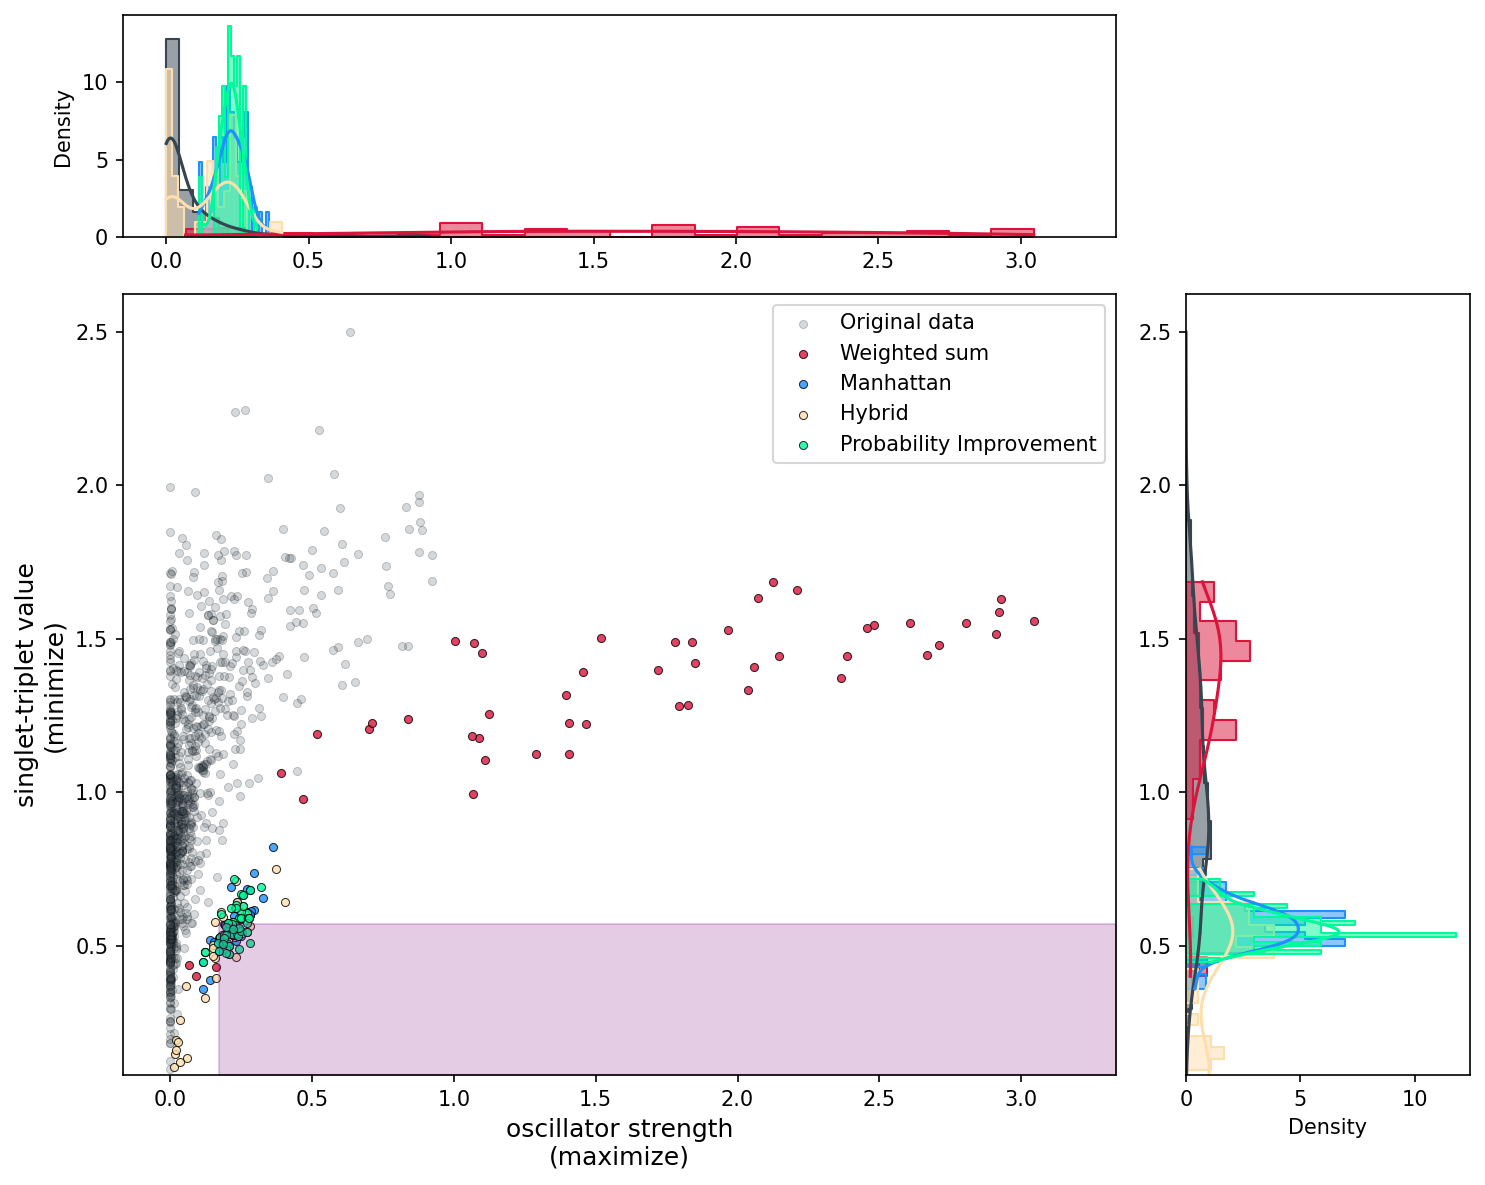

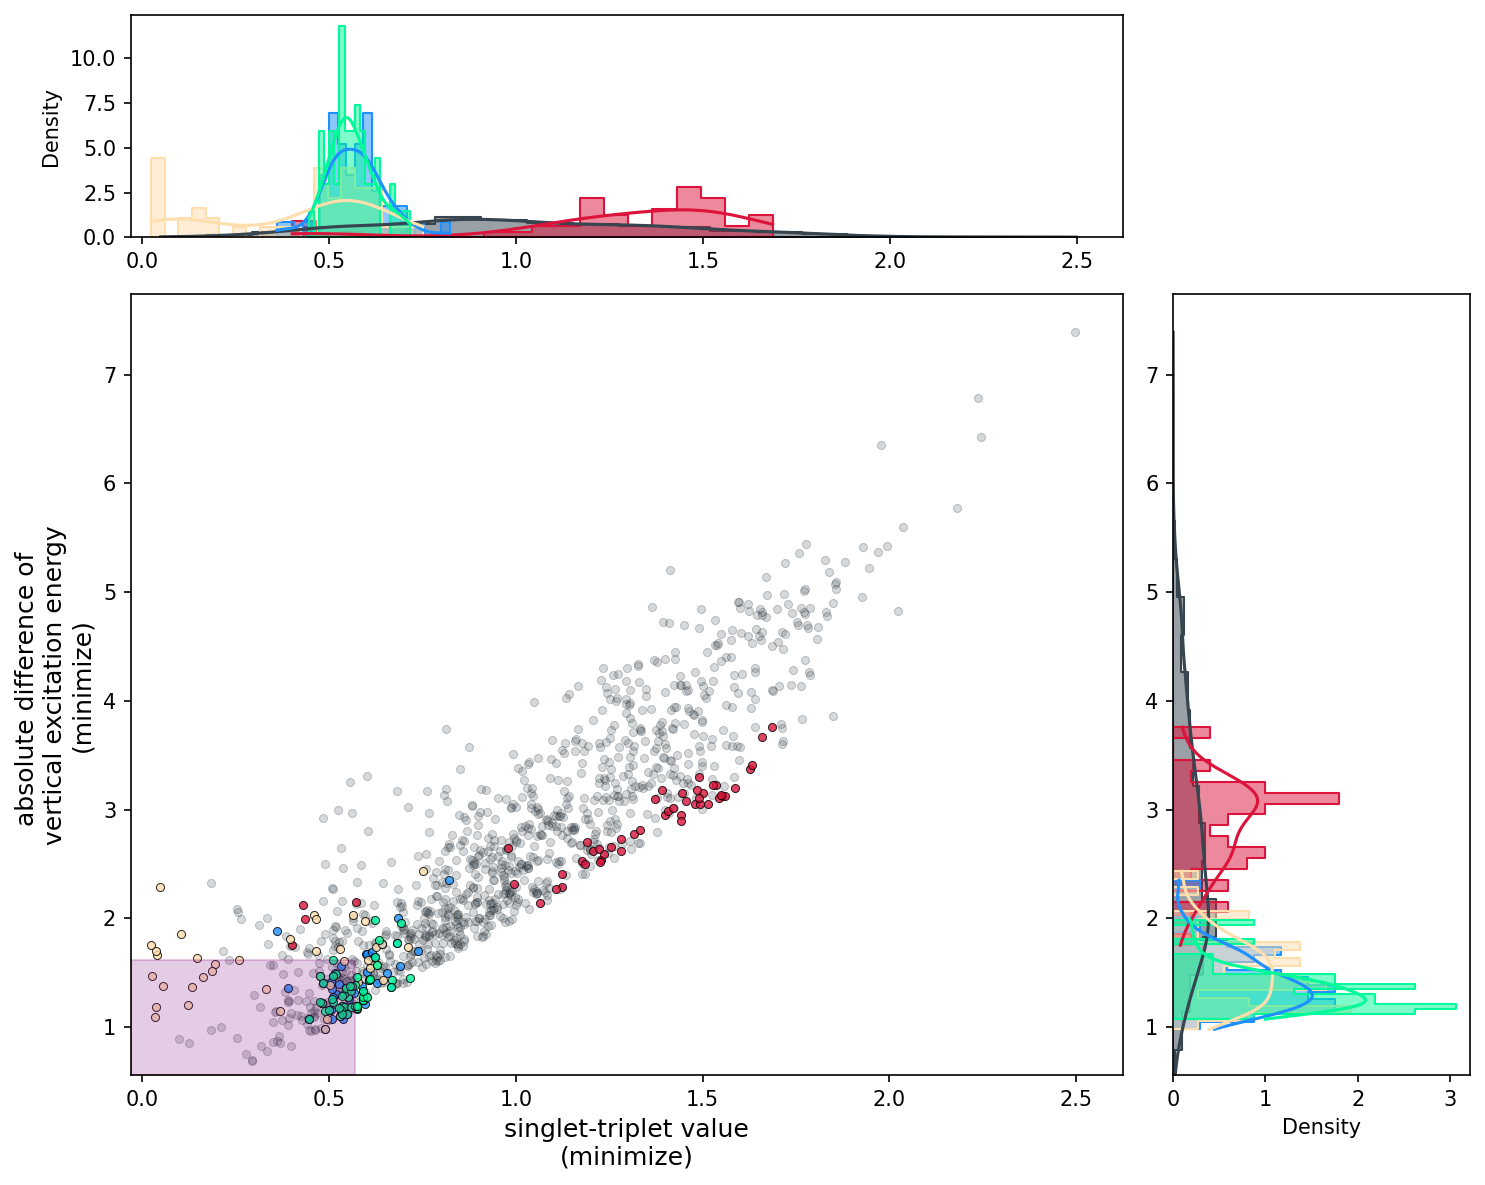

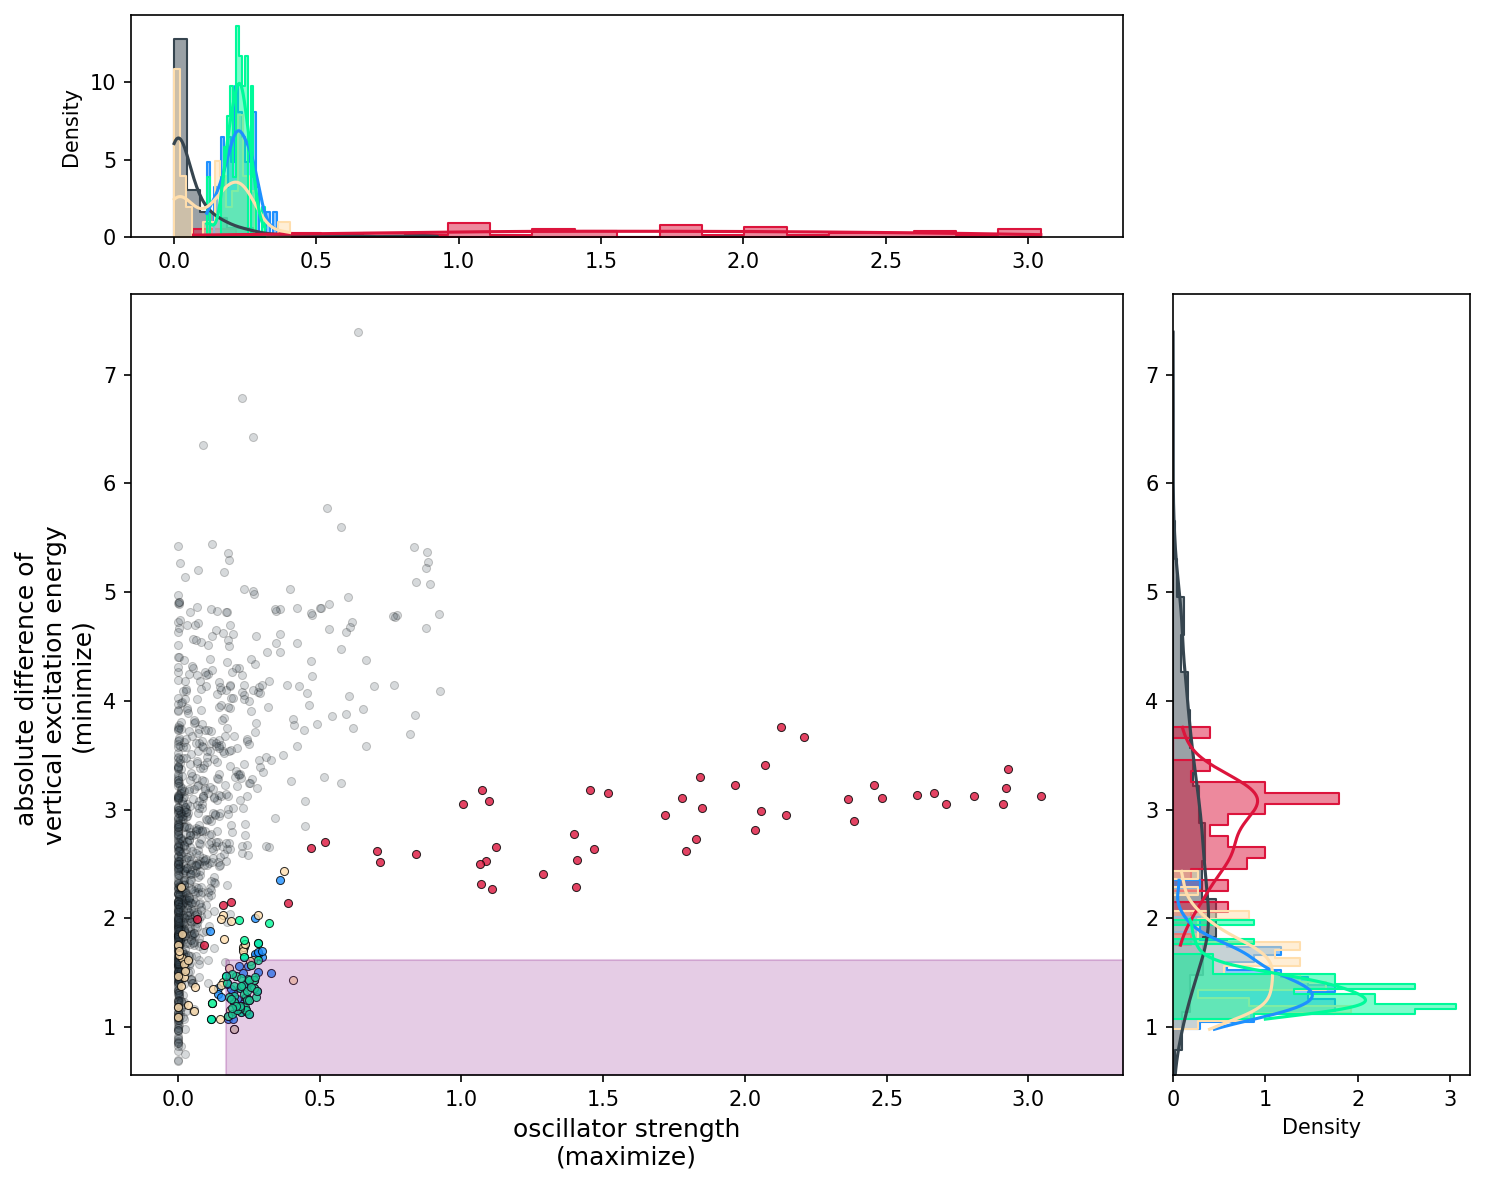

In [8]:
def create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, target_columns, target_objective, cutoff_dict,
                 purple_line_label="top-15% cutoff", top_num=50, legend=False):
    target_name_dict = {"Ea": "activation energy", "Er": "reaction energy","singlet-triplet value":"singlet-triplet value", 
                        "oscillator strength":"oscillator strength", "abs_diff_vee":"absolute difference of \nvertical excitation energy"}
    start_point = [cutoff_dict[target] for target in target_columns]
    normalized_target_columns = [target for target in target_columns]
        
    fig = plt.subplots(dpi=150, figsize = (10, 8))
    ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)
    ax_histx = plt.subplot2grid((4, 4), (0, 0), colspan=3)
    ax_histy = plt.subplot2grid((4, 4), (1, 3), rowspan=3)
    
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            continue
        data_dict.update({sub_dir: data_dict[sub_dir][:top_num]})
    extreme_point = [min(pd.concat([*data_dict.values()], axis=0)[target]) if target_objective[target]=="minimize" 
                     else max(pd.concat([*data_dict.values()], axis=0)[target]) for target in target_columns]
    all_data_x = []
    all_data_y = []
    all_labels = []
    all_colors = []
    for sub_dir in sub_dir_name:
        data = data_dict[sub_dir]
        data_x = [x for x in data[normalized_target_columns[0]]]
        data_y = [y for y in data[normalized_target_columns[1]]]
        all_data_x += data_x
        all_data_y += data_y
        all_labels += [sub_dir]*len(data_x)
        all_colors += [color_dict[sub_dir]]*len(data_x)
        if sub_dir == "original data":
            alpha = 0.2
        else:
            alpha = 0.8
    
    all_data = pd.DataFrame({"x":all_data_x, "y":all_data_y, "label":all_labels, "color":all_colors})
    for sub_dir in sub_dir_name:
        sns.histplot(all_data[all_data["label"]==sub_dir], x="x", bins=20, ax=ax_histx, color=color_dict[sub_dir],#hue="label", palette=color_dict,
                     kde=True, element='step', stat='density', legend=False)
        sns.histplot(all_data[all_data["label"]==sub_dir], y="y", bins=20, ax=ax_histy, color=color_dict[sub_dir],#hue="label", palette=color_dict,
                     kde=True, element='step', stat='density', legend=False)
#     ax_histx.set_xticks([])
    ax_histx.set_xlabel(None)
#     ax_histy.set_yticks([])
    ax_histy.set_ylabel(None)

    
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            alpha = 0.2
        else:
            alpha = 0.8
        ax_scatter.scatter(all_data[all_data["label"]==sub_dir]["x"], all_data[all_data["label"]==sub_dir]["y"], 
                       c=color_dict[sub_dir], marker='o', alpha=alpha ,s=15, linewidths=0.5, edgecolors="black")
    if legend:
        ax_scatter.legend(["Original data","Weighted sum","Manhattan", "Hybrid", "Probability Improvement"])
    
    start_x, start_y = start_point
    end_x, end_y = extreme_point
    
    end_x += (end_x - start_x)*0.1
    end_y -= (end_y - start_y)*0.1
    print("S And E")
    print(start_point, extreme_point)
    print(end_x, end_y)
    
    ax_scatter.fill_between([start_x, end_x], [start_y, start_y], [end_y, end_y], color='purple', alpha=0.2, interpolate=True)
    if target_objective[target_columns[0]] == "maximize":
        ax_scatter.set_xlim(right=end_x)
        ax_histx.set_xlim(right=end_x)
    else:
        ax_scatter.set_xlim(left=end_x)
        ax_histx.set_xlim(left=end_x)
    if target_objective[target_columns[1]] == "maximize":
        ax_scatter.set_ylim(top=end_y)
        ax_histy.set_ylim(top=end_y)
    else:
        ax_scatter.set_ylim(bottom=end_y)
        ax_histy.set_ylim(bottom=end_y)
    ax_scatter.set_xlabel(target_name_dict[target_columns[0]]+"\n("+target_objective[target_columns[0]]+")",fontsize=12)
    ax_scatter.set_ylabel(target_name_dict[target_columns[1]]+"\n("+target_objective[target_columns[1]]+")",fontsize=12)
    
    plt.tight_layout()

data_set = "organic_emitter" 
data_path = "../Tartarus/datasets/gdb13.csv"
root_dir = "../RESULTS/{}".format(data_set)
cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)

""" The singlet-triplet value shoulb time minus one !!! """
for smiles, target_values in predict_dict.items():
    stv, osv, mov = target_values
    predict_dict[smiles] = (-stv, osv, mov)
    
sub_dir_name = ["original data", "janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]
target_columns = ["singlet-triplet value", "oscillator strength", "abs_diff_vee"]
scaler_dict = {"singlet-triplet value": (1.003, 0.396), "oscillator strength": (0.086, 0.149), "abs_diff_vee": (2.688, 1.038),}

# top-15% cutoff
cutoff_dict = {"singlet-triplet value":0.57068, "oscillator strength":0.1706886, "abs_diff_vee": 1.615238}

target_objective = {"singlet-triplet value":"minimize", 
                    "oscillator strength":"maximize", 
                    "abs_diff_vee":"minimize"}

# color_dict = {"original data": "black", "janus_scaler":"red", "janus_hybrid":"orange", "janus_uncertainty":"green", "janus_utopian":"blue"}
color_dict = {"original data": "#36454F", "janus_scaler":"crimson", "janus_hybrid":"navajowhite",
              "janus_uncertainty":"mediumspringgreen", "janus_utopian":"dodgerblue"}
num_fold = 15
normalized_cutoff_dict = { key: (value-scaler_dict[key][0])/scaler_dict[key][1] for key, value in cutoff_dict.items() }


data = pd.read_csv(data_path)
data["singlet-triplet value"] = data["singlet-triplet value"]
data = shuffle(calc_normalized_data(data, target_columns, scaler_dict),random_state=13)[:1000]
data_dict = sample_data(sub_dir_name, target_columns, scaler_dict, cache_dict, num_fold, root_dir,sample_num=-1)
data_dict.update({"original data": data})
# for sub_dir in sub_dir_name:
#     data_dict[sub_dir]["singlet-triplet value"] *= (-1)

compute_hit_rate(data_dict, sub_dir_name, cutoff_dict, target_objective, top_list=[10,50,100])
# for creating a responsive plot
# del data_dict["janus_scaler"]
# %matplotlib widget
# create3Dplot(sub_dir_name,
#              data_dict, color_dict, target_columns, target_objective, cutoff_dict,purple_line_label="top-15% cutoff",top_num=50)
# plt.legend(["Original data","Weighted sum","Manhattan", "Hybrid", "Uncertainty"])

create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, ["oscillator strength", "singlet-triplet value"], target_objective, cutoff_dict,top_num=50,purple_line_label="top-15% cutoff",legend=True)
create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, ["singlet-triplet value", "abs_diff_vee"], target_objective, cutoff_dict,top_num=50,purple_line_label="top-15% cutoff")
create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, ["oscillator strength", "abs_diff_vee"], target_objective, cutoff_dict,top_num=50,purple_line_label="top-15% cutoff")

In [6]:
data_dict["janus_utopian"][data_dict["janus_utopian"]["fitness"]==0]
def pass_cutoff_data(df, target_columns, cutoff_dict, target_objective):
    subdata = df.copy()
    for target in target_columns:
        cutoff = cutoff_dict[target]
        objective = target_objective[target]
        if objective == "minimize":
            subdata = subdata[subdata[target] <= cutoff]
        else:
            subdata = subdata[subdata[target] >= cutoff]
    return subdata

df = pass_cutoff_data(data_dict["janus_utopian"][data_dict["janus_utopian"]["fitness"]==0], target_columns, cutoff_dict, target_objective)
print(len(df))
df

17


,singlet-triplet value,oscillator strength,abs_diff_vee,smiles,normalized singlet-triplet value,normalized oscillator strength,normalized abs_diff_vee,fitness
3,0.535570,0.196501,1.282883,O=C(Oc1cnc[nH]1)c1ccns1,-3.885278,0.741618,-1.353677,0.0
4,0.509232,0.176980,1.071113,C=CC(=O)Oc1ccn2cn[nH]c12,-3.818768,0.610604,-1.557694,0.0
5,0.549038,0.250832,1.120833,O=C(Oc1ncc[nH]1)c1nccs1,-3.919289,1.106258,-1.509795,0.0
7,0.507570,0.186165,1.347562,O=C(Oc1cnc[nH]1)c1cncs1,-3.814572,0.672250,-1.291367,0.0
10,0.554578,0.208837,1.256503,O=C(Oc1ccn[nH]1)c1nncs1,-3.933278,0.824412,-1.379091,0.0
13,0.499052,0.207262,1.154978,O=C(Oc1ncc[nH]1)c1ccns1,-3.793061,0.813840,-1.476900,0.0
18,0.537896,0.195109,1.078165,C=CC(=O)Oc1ncn2cc[nH]c12,-3.891152,0.732278,-1.550901,0.0
22,0.550657,0.241244,1.280437,O=C(Oc1ccco1)c1nccs1,-3.923377,1.041906,-1.356033,0.0
28,0.481578,0.203957,1.114387,O=C(Oc1cc(O)co1)c1nccs1,-3.748935,0.791660,-1.516005,0.0
30,0.506614,0.199919,1.154498,C=COc1ccc(Oc2nncs2)[nH]1,-3.812156,0.764559,-1.477362,0.0


### Reaction substrate design (reactivity)

original data, top-10 hit rate: 0.0%
janus_scaler, top-10 hit rate: 20.0%
janus_utopian, top-10 hit rate: 0.0%
janus_hybrid, top-10 hit rate: 40.0%
janus_uncertainty, top-10 hit rate: 40.0%
original data, top-50 hit rate: 0.0%
janus_scaler, top-50 hit rate: 8.0%
janus_utopian, top-50 hit rate: 10.0%
janus_hybrid, top-50 hit rate: 16.0%
janus_uncertainty, top-50 hit rate: 22.0%
original data, top-100 hit rate: 0.0%
janus_scaler, top-100 hit rate: 7.000000000000001%
janus_utopian, top-100 hit rate: 11.0%
janus_hybrid, top-100 hit rate: 11.0%
janus_uncertainty, top-100 hit rate: 22.0%
S And E
[86.96834, -5.46226] [110.0901632476412, -19.98403267991017]
112.40234557240532 -18.531855411919153


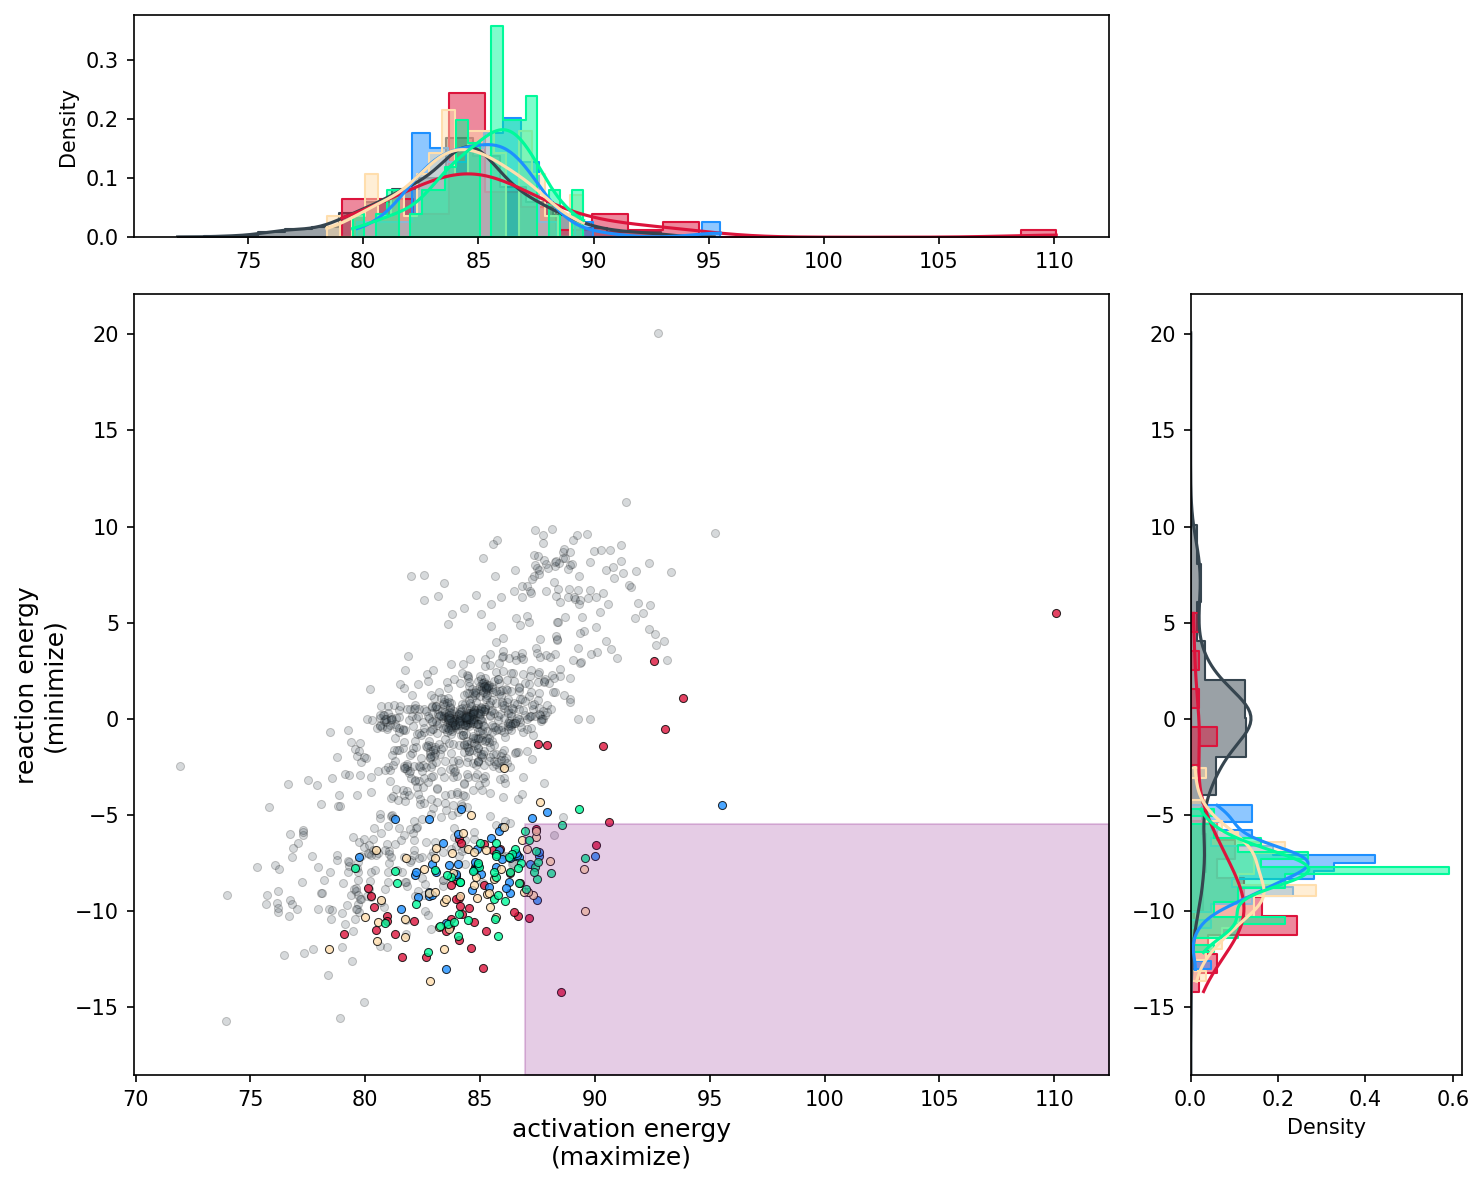

In [9]:
num_samples_in_each_fold = 15

data_set = "reactivity" # 
data_path = "../Tartarus/datasets/reactivity.csv"
root_dir = "../RESULTS/{}".format(data_set)
cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["original data", "janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]
target_columns = ["Ea", "Er",]
scaler_dict = {"Ea": (84.104, 3.076), "Er": (-0.749, 4.507),}
# top-12.5%
# cutoff_dict = {"Ea": 87.3226545, "Er": -6.41327,}
# top-15%
cutoff_dict = {"Ea": 86.96834, "Er": -5.46226,} 
target_objective = {"Ea":"maximize", 
                    "Er":"minimize",}
# color_dict = {"original data": "black", "janus_scaler":"red", "janus_hybrid":"orange", "janus_uncertainty":"green", "janus_utopian":"blue"}
color_dict = {"original data": "#36454F", "janus_scaler":"crimson", "janus_hybrid":"navajowhite",
              "janus_uncertainty":"mediumspringgreen", "janus_utopian":"dodgerblue"}
num_fold = 15


data = pd.read_csv(data_path)
data = shuffle(calc_normalized_data(data, target_columns, scaler_dict),random_state=12)[:1000]
data_dict = sample_data(sub_dir_name, target_columns, scaler_dict, cache_dict, num_fold, root_dir,sample_num=-1)
data_dict.update({"original data": data})
compute_hit_rate(data_dict, sub_dir_name, cutoff_dict, target_objective, top_list=[10,50,100])


create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, target_columns, target_objective, cutoff_dict,top_num=50,purple_line_label="top-15% cutoff")


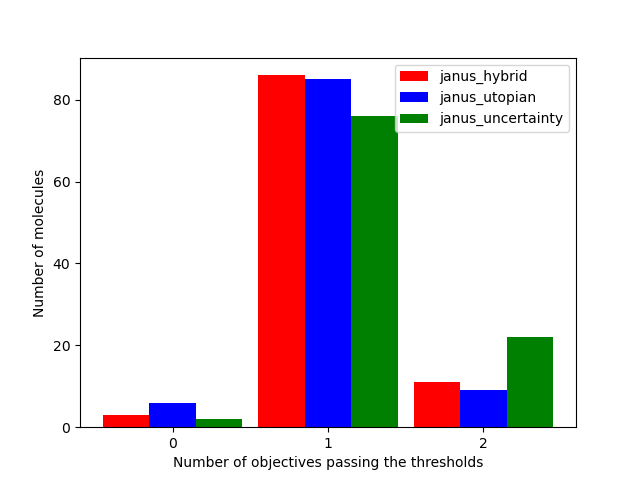

In [66]:
create_cutoff_plot(data_dict, ["janus_hybrid","janus_utopian", "janus_uncertainty"], target_columns, target_objective, cutoff_dict, num_fold, color_dict)

In [11]:
data_set = "organic_emitter"
data_path = "../Tartarus/datasets/gdb13.csv"
data = pd.read_csv(data_path)
target_columns = ["singlet-triplet value", "oscillator strength", "abs_diff_vee"]
data[target_columns].corr()

,singlet-triplet value,oscillator strength,abs_diff_vee
singlet-triplet value,1.000000,0.572616,0.897225
oscillator strength,0.572616,1.000000,0.530227
abs_diff_vee,0.897225,0.530227,1.000000


# Plot Abstract

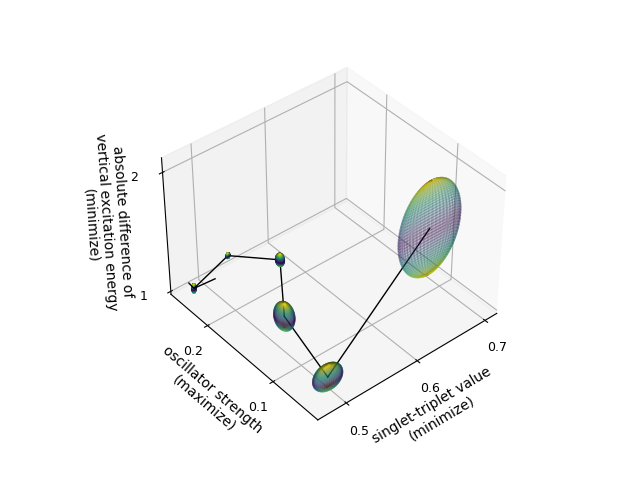

In [100]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.colors import Normalize
import seaborn as sns

# %matplotlib widget


# 定義點的位置和對應的各軸變異量
points = np.array([
    [1, 0.5, 3, 0.1, 2.2, 0.3],   # X, Y, Z, Variance_x, Variance_y, Variance_z
    [6, 1, 6, 0.4, 0.5, 1.6],
    [7, 8, 6, 0.1, 1.8, 0.9],
    [10, 3, 12, 1.0, 2.1, 0.2]
])

data = pd.read_csv("janus_uncertainty_organic_emitter_record_prediction.csv")
data = data[data["fitness"] > 0].drop_duplicates(subset=["smiles"]).reset_index(drop=True)
columns = ['singlet-triplet value', 'oscillator strength', 'abs_diff_vee', 'singlet-triplet value_mve_uncal_var',
       'oscillator strength_mve_uncal_var', 'abs_diff_vee_mve_uncal_var']
points = np.array(data.iloc[[0,2,12,17,22,24]][columns].iloc[::-1])
scale_ratio = 2
points[:,3:] = points[:,3:]*scale_ratio

# 橢球的繪製函數
def draw_ellipsoid(x_center, y_center, z_center, width, height, depth):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = width * np.outer(np.cos(u), np.sin(v)) + x_center
    y = height * np.outer(np.sin(u), np.sin(v)) + y_center
    z = depth * np.outer(np.ones(np.size(u)), np.cos(v)) + z_center
    
    # 計算顏色映射
    cmap = sns.color_palette("viridis", as_cmap=True)
    distances = np.sqrt((x-x_center)**2 + (y-y_center)**2 + (z-z_center)**2)
    norm = Normalize(vmin=np.min(distances), vmax=np.max(distances))
    colors = cmap(norm(distances))
    
    ax.plot_surface(x, y, z, facecolors=colors, alpha=0.1)

# def draw_optimization_progress(points):
    # 創建一個新的圖和一個3D軸
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# 對每個點畫出對應的橢球
for point in points:
    draw_ellipsoid(point[0], point[1], point[2], point[3], point[4], point[5])


# 使用線段連接前面的點
for i in range(len(points) - 2):
    start_point = points[i]
    end_point = points[i + 1]
    ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]], 
            color='black', linewidth=1,)

# 使用箭頭連接最後兩個點
start_point = points[-2]
end_point = points[-1]
ax.quiver(start_point[0], start_point[1], start_point[2],
          end_point[0] - start_point[0], end_point[1] - start_point[1], end_point[2] - start_point[2],
          color='black', arrow_length_ratio=0.25, linewidth=1, hatch="o")

# 設定軸標籤
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.zaxis.set_tick_params(labelsize=9)
ax.set_xticks(ticks=[0.5, 0.6, 0.7])
ax.set_yticks(ticks=[0.1, 0.2,])
ax.set_zticks(ticks=[1, 2])
ax.set_xlabel('singlet-triplet value \n(minimize)')
ax.set_ylabel('oscillator strength \n(maximize)')
ax.set_zlabel('absolute difference of \nvertical excitation energy \n(minimize)')

ax.view_init(elev=40, azim=230)
plt.savefig("optimization_progress.svg", format="svg")
    
# for xx in range(0,360, 10):
#     for yy in range(0,360,10):
#         ax.view_init(elev=xx, azim=yy)
#         plt.savefig(f"figures_temp/f_{xx}_{yy}.png")#, format="svg")
# 顯示圖表
# plt.show()


In [103]:
data.iloc[[0,2,12,17,22,24]]["smiles"]

0                   O=C(Oc1ccc[nH]1)c1pccs1
2                   O=C(Oc1ccc[nH]1)c1cccs1
12                     O=C(Oc1cccs1)c1ncsn1
17                  O=C(Nc1ncc[nH]1)c1ccsn1
22      O=C(OC=Cc1ncncc1Nc1ccc[nH]1)c1pccs1
24    NC(=CC(=O)Oc1ccc[nH]1)c1cocc1-c1pccs1
Name: smiles, dtype: object